Initialisation stage

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib.dates as mdates
import numpy as np
import time
import seaborn as sns
import math
from datetime import timedelta, date

import project_01 as p1

We read a weekly file (week ending 2 Feb 2019) from the MTA website to determine its structure

This instead reads num_weeks weeks of data starting from week ending 2 Feb 2019

In [47]:
#initialise the number of weeks for the dataset
num_weeks = 10

#initialise the date for the first week of the dataset (week ending on start_date)
start_date = filedate = pd.Timestamp('2019-02-02 00:00:00')

#initialise the regex for the MTA turnstile url
filename_regex = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

filelist = []

for numfiles in range (num_weeks):

    # create the appropriate filename for the week
    filedate_str = str(filedate.year)[2:4] + str(filedate.month).zfill(2) + str(filedate.day).zfill(2)
    filename = filename_regex.format(filedate_str)

    # read the file and append it to the list of files to be concacated
    df = pd.read_csv(filename, parse_dates=[['DATE', 'TIME']], keep_date_col=True)
    filelist.append(df)

    # advance to the next week
    filedate += pd.Timedelta(days=7)

mta_test = pd.concat(filelist, axis=0, ignore_index=True)


In [3]:
mta_test.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
2033683,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-04-05,05:00:00,REGULAR,5554,374
2033684,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-04-05,09:00:00,REGULAR,5554,374
2033685,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-04-05,13:00:00,REGULAR,5554,374
2033686,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-04-05,17:00:00,REGULAR,5554,374
2033687,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-04-05,21:00:00,REGULAR,5554,374


The 'ENTRIES' column name is dirty!

In [4]:
mta_test.columns.values

array(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE',
       'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype=object)

Rename the column

In [5]:
mta_test.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)

In [6]:
mta_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033688 entries, 0 to 2033687
Data columns (total 11 columns):
 #   Column    Dtype         
---  ------    -----         
 0   C/A       object        
 1   UNIT      object        
 2   SCP       object        
 3   STATION   object        
 4   LINENAME  object        
 5   DIVISION  object        
 6   DATE      datetime64[ns]
 7   TIME      object        
 8   DESC      object        
 9   ENTRIES   int64         
 10  EXITS     int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 170.7+ MB


We found that the DESC column has a small amout of 'RECOVR AUD', which we learned refers to audits updated 

In [7]:
mta_test['DESC'].value_counts()

REGULAR       2023901
RECOVR AUD       9787
Name: DESC, dtype: int64

The names of stations are not in a consistant format

In [8]:
mta_test['STATION'].value_counts().head(20)

34 ST-PENN STA     42807
FULTON ST          40171
23 ST              30472
GRD CNTRL-42 ST    27710
86 ST              25266
CANAL ST           24655
34 ST-HERALD SQ    23626
CHAMBERS ST        22896
59 ST              22337
42 ST-PORT AUTH    21942
TIMES SQ-42 ST     21381
WALL ST            20939
ATL AV-BARCLAY     20472
14 ST              18315
125 ST             18304
PATH NEW WTC       17829
59 ST COLUMBUS     17254
CORTLANDT ST       16519
28 ST              16377
14 ST-UNION SQ     16053
Name: STATION, dtype: int64

In [9]:
mta_test['TIME'].value_counts()

08:00:00    144166
04:00:00    144158
20:00:00    144113
16:00:00    144106
12:00:00    144091
             ...  
03:23:09         1
13:32:08         1
16:40:03         1
14:21:10         1
22:11:19         1
Name: TIME, Length: 54866, dtype: int64

Grouping by Station, C/A, unit, SCP (and optionally date), and then taking the difference between max and min of entry and exit counters

Remove rows with erronous jumps

In [10]:

(mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.max() - mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.min())

STATION    C/A   UNIT  SCP       DATE      
1 AV       H007  R248  00-00-00  2019-01-26    2753
                                 2019-01-27    2070
                                 2019-01-28    3842
                                 2019-01-29    4201
                                 2019-01-30    4274
                                               ... 
ZEREGA AV  R419  R326  00-05-01  2019-04-01       0
                                 2019-04-02       0
                                 2019-04-03       0
                                 2019-04-04       0
                                 2019-04-05       0
Name: ENTRIES, Length: 337621, dtype: int64

In [11]:
mta_test['EXITS']

0          2347673
1          2347688
2          2347773
3          2347849
4          2347911
            ...   
2033683        374
2033684        374
2033685        374
2033686        374
2033687        374
Name: EXITS, Length: 2033688, dtype: int64

In [12]:
## gets the number of entries and exits
mta_entries = mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.max() - mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.min()

mta_exits = mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).EXITS.max() - mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).EXITS.min()


This is what the grouped data looks like before flattening

In [13]:
print(mta_entries)
print(mta_exits)

STATION    C/A   UNIT  SCP       DATE      
1 AV       H007  R248  00-00-00  2019-01-26    2753
                                 2019-01-27    2070
                                 2019-01-28    3842
                                 2019-01-29    4201
                                 2019-01-30    4274
                                               ... 
ZEREGA AV  R419  R326  00-05-01  2019-04-01       0
                                 2019-04-02       0
                                 2019-04-03       0
                                 2019-04-04       0
                                 2019-04-05       0
Name: ENTRIES, Length: 337621, dtype: int64
STATION    C/A   UNIT  SCP       DATE      
1 AV       H007  R248  00-00-00  2019-01-26    3718
                                 2019-01-27    3120
                                 2019-01-28    3597
                                 2019-01-29    3831
                                 2019-01-30    3534
                                    

There are big unexplained jumps in counter numbers at certain parts of the data (see last three rows below)

Flatten and merge the entry and exit datasets

In [14]:
mta_entries_flat = mta_entries.reset_index()
mta_exits_flat = mta_exits.reset_index()

mta_entries_exits = pd.merge(mta_entries_flat, mta_exits_flat, how='outer')
print(mta_entries_exits)

STATION   C/A  UNIT       SCP       DATE  ENTRIES  EXITS
0            1 AV  H007  R248  00-00-00 2019-01-26     2753   3718
1            1 AV  H007  R248  00-00-00 2019-01-27     2070   3120
2            1 AV  H007  R248  00-00-00 2019-01-28     3842   3597
3            1 AV  H007  R248  00-00-00 2019-01-29     4201   3831
4            1 AV  H007  R248  00-00-00 2019-01-30     4274   3534
...           ...   ...   ...       ...        ...      ...    ...
337616  ZEREGA AV  R419  R326  00-05-01 2019-04-01        0      0
337617  ZEREGA AV  R419  R326  00-05-01 2019-04-02        0      0
337618  ZEREGA AV  R419  R326  00-05-01 2019-04-03        0      2
337619  ZEREGA AV  R419  R326  00-05-01 2019-04-04        0      0
337620  ZEREGA AV  R419  R326  00-05-01 2019-04-05        0      0

[337621 rows x 7 columns]


Append weekday and traffic column to dataset

In [15]:
mta_entries_exits['WEEKDAY'] = mta_entries_exits['DATE'].dt.day_name()
mta_entries_exits['TRAFFIC'] = mta_entries_exits['ENTRIES'] + mta_entries_exits['EXITS']
mta_entries_exits['WEEKDAY_INDEX'] = mta_entries_exits['DATE'].dt.weekday

In [16]:
mta_entries_exits = mta_entries_exits[mta_entries_exits.TRAFFIC < 50000]

Group by station and date (including weekday) and flatten the resultant dataset

In [17]:
mta_bystation = mta_entries_exits.groupby(['STATION','DATE','WEEKDAY', 'WEEKDAY_INDEX']).sum().reset_index()

In [18]:
mta_bystation

,STATION,DATE,WEEKDAY,WEEKDAY_INDEX,ENTRIES,EXITS,TRAFFIC
0,1 AV,2019-01-26,Saturday,5,15001,18465,33466
1,1 AV,2019-01-27,Sunday,6,11887,14116,26003
2,1 AV,2019-01-28,Monday,0,18617,21205,39822
3,1 AV,2019-01-29,Tuesday,1,19714,23064,42778
4,1 AV,2019-01-30,Wednesday,2,19708,22868,42576
...,...,...,...,...,...,...,...
26417,ZEREGA AV,2019-04-01,Monday,0,2725,2343,5068
26418,ZEREGA AV,2019-04-02,Tuesday,1,2716,2341,5057
26419,ZEREGA AV,2019-04-03,Wednesday,2,2840,2410,5250
26420,ZEREGA AV,2019-04-04,Thursday,3,2829,2378,5207


In [19]:
mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"]

,STATION,DATE,WEEKDAY,WEEKDAY_INDEX,ENTRIES,EXITS,TRAFFIC
4268,34 ST-PENN STA,2019-01-26,Saturday,5,77849,75662,153511
4269,34 ST-PENN STA,2019-01-27,Sunday,6,66531,63272,129803
4270,34 ST-PENN STA,2019-01-28,Monday,0,161183,145887,307070
4271,34 ST-PENN STA,2019-01-29,Tuesday,1,169162,155165,324327
4272,34 ST-PENN STA,2019-01-30,Wednesday,2,165812,153787,319599
...,...,...,...,...,...,...,...
4333,34 ST-PENN STA,2019-04-01,Monday,0,160551,141210,301761
4334,34 ST-PENN STA,2019-04-02,Tuesday,1,162188,137232,299420
4335,34 ST-PENN STA,2019-04-03,Wednesday,2,161801,142129,303930
4336,34 ST-PENN STA,2019-04-04,Thursday,3,163753,142380,306133


Which are the top 5 stations by entries and exits?

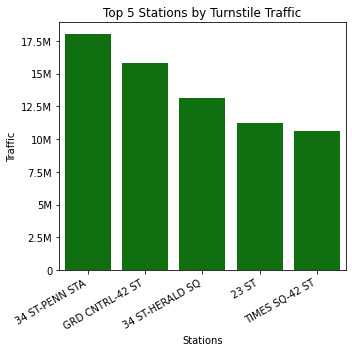

In [20]:
mta_top5 = mta_bystation.groupby('STATION').sum().reset_index().sort_values('TRAFFIC', ascending=False).head(5)

fig = plt.figure(figsize=(5,5))
sns.barplot(data=mta_top5, x = 'STATION', y = 'TRAFFIC', color='green').set(title='Top 5 Stations by Turnstile Traffic', xlabel='Stations', ylabel='Traffic')
axs = plt.gca()
axs.yaxis.set_major_formatter(tick.FuncFormatter(p1.reformat_large_tick_values));
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

plt.savefig('top5stations-' + str(num_weeks) + 'wk.svg')


In [23]:
filter = (mta_test['STATION'] == '125 ST') & (mta_test['C/A'] == 'R258') & (mta_test['SCP'] == '00-03-03')
mta_test[filter].head(30) 

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
164231,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,00:00:00,REGULAR,3888393,2659898
164232,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,04:00:00,REGULAR,3888433,2659961
164233,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,08:00:00,REGULAR,3888523,2660074
164234,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,12:00:00,REGULAR,3888767,2660272
164235,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,16:00:00,REGULAR,3889047,2660460
164236,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,20:00:00,REGULAR,3889323,2660636
164237,R258,R132,00-03-03,125 ST,456,IRT,2019-01-27,00:00:00,REGULAR,3889445,2660788
164238,R258,R132,00-03-03,125 ST,456,IRT,2019-01-27,04:00:00,REGULAR,3889476,2660850
164239,R258,R132,00-03-03,125 ST,456,IRT,2019-01-27,08:00:00,REGULAR,3889520,2660934
164240,R258,R132,00-03-03,125 ST,456,IRT,2019-01-27,12:00:00,REGULAR,3889667,2661092


In [24]:
mta_entries_exits.TRAFFIC.describe()

count    337389.000000
mean       1687.082827
std        1555.220032
min           0.000000
25%         508.000000
50%        1345.000000
75%        2490.000000
max       49728.000000
Name: TRAFFIC, dtype: float64

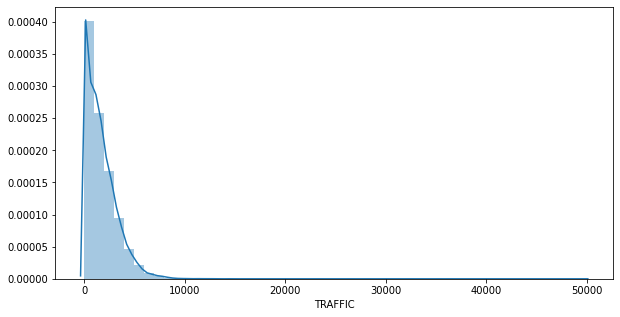

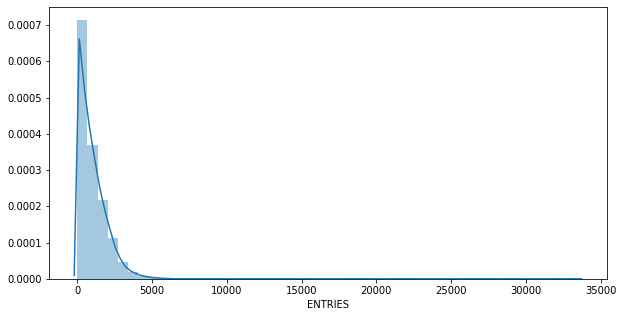

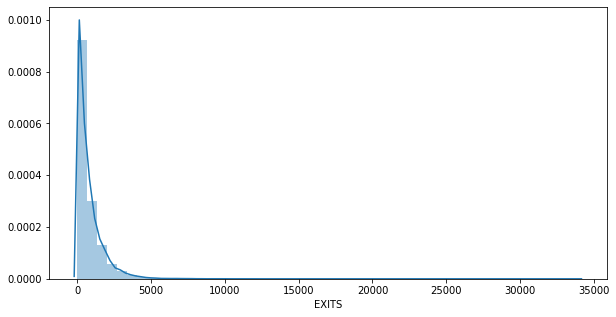

In [40]:
fig, ax = plt.subplots(ncols=1, figsize=(10,5))
sns.distplot(mta_entries_exits.TRAFFIC); #.set_yscale('log');
fig, ax = plt.subplots(ncols=1, figsize=(10,5))
sns.distplot(mta_entries_exits.ENTRIES); #.set_yscale('log'));
fig, axs = plt.subplots(ncols=1, figsize=(10,5))
sns.distplot(mta_entries_exits.EXITS); #.set_yscale('log'));


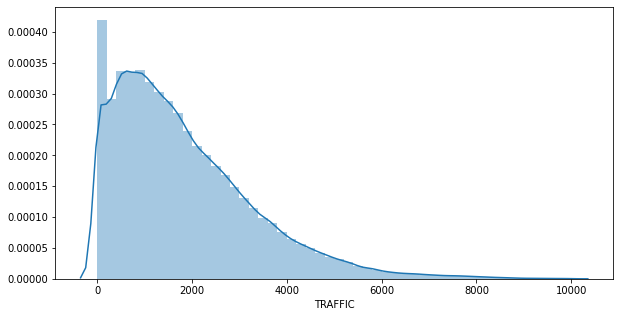

In [45]:
fig, ax = plt.subplots(ncols=1, figsize=(10,5))
sns.distplot(mta_entries_exits[(mta_entries_exits.TRAFFIC < 10000) & (mta_entries_exits.TRAFFIC > 0)].TRAFFIC);

Plot the traffic for top 5 stations; weekends are highlighted 

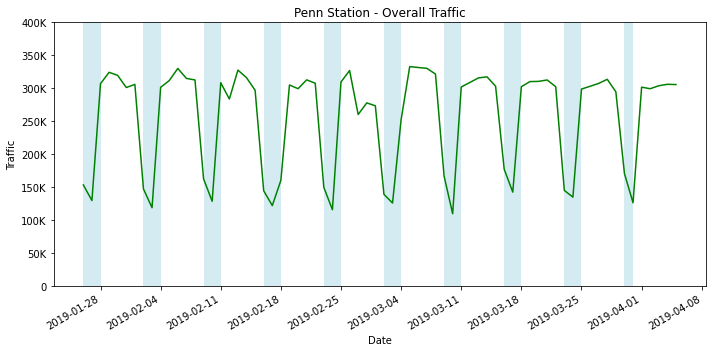

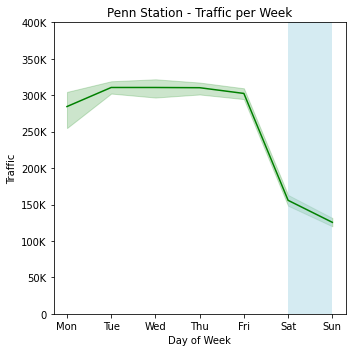

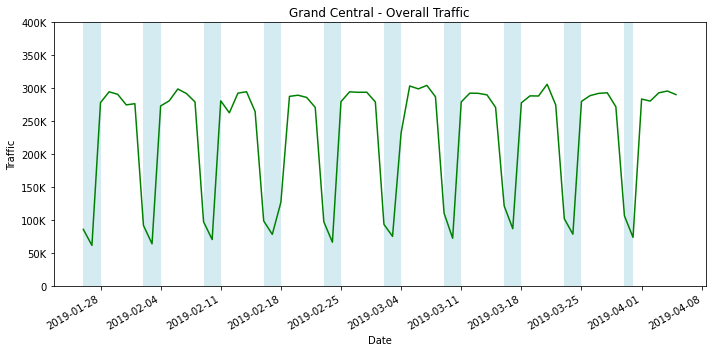

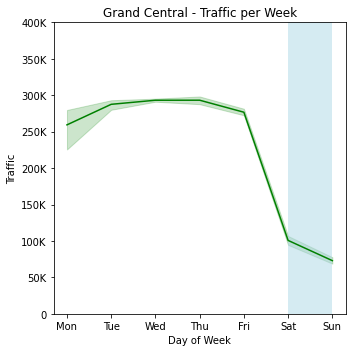

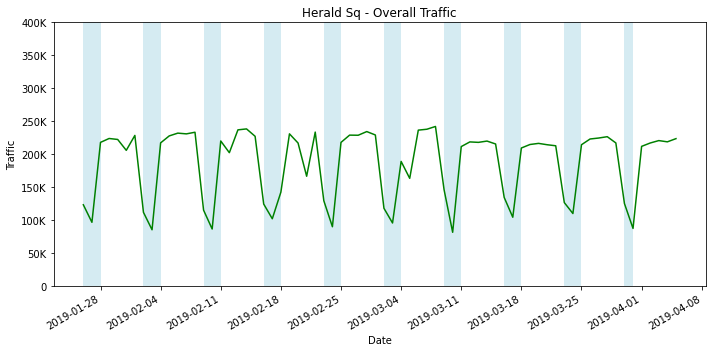

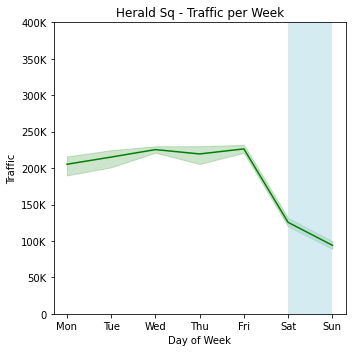

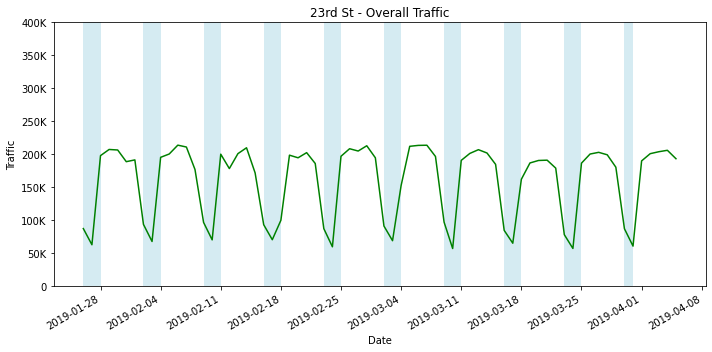

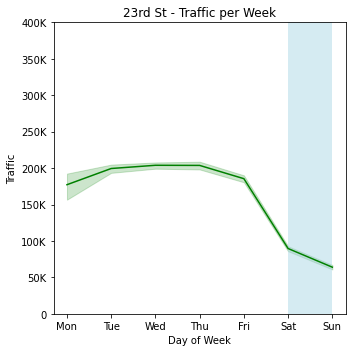

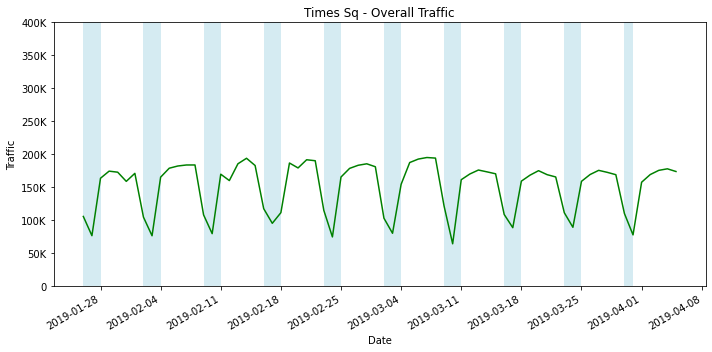

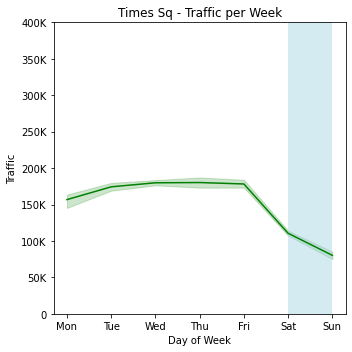

In [26]:
mta = {}
plot_num = 0

mta['penn'] = [mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"], 'Penn Station']
mta['grdcntrl'] = [mta_bystation[mta_bystation.STATION == "GRD CNTRL-42 ST"], 'Grand Central']
mta['heraldsq'] = [mta_bystation[mta_bystation.STATION == "34 ST-HERALD SQ"], 'Herald Sq']
mta['23rd'] = [mta_bystation[mta_bystation.STATION == "23 ST"], '23rd St']
#mta['portauth'] = [mta_bystation[mta_bystation.STATION == "42 ST-PORT AUTH"], 'Port Auth']
#mta['unionsq'] = [mta_bystation[mta_bystation.STATION == "14 ST-UNION SQ"], 'Union Sq']
mta['timessq'] = [mta_bystation[mta_bystation.STATION == "TIMES SQ-42 ST"], 'Times Sq']

for station in mta:
    
    '''
    plot total traffic for each top 5 station over the whole time period
    '''

    # scale width of plot logrimatically with number of weeks
    fig, axs = plt.subplots(nrows=1, figsize=(5*math.ceil(num_weeks / 5),5))
    sns.lineplot(data = mta[station][0], x='DATE', y='TRAFFIC', color='green', ax=axs).set(ylim=(0,400000),title=mta[station][1] + ' - Overall Traffic', xlabel='Date', ylabel='Traffic')

    # highlight weekends
    weekend_indices = p1.find_weekend_indices(mta[station][0].DATE.tolist())
    p1.highlight_datetimes(weekend_indices, axs, mta[station][0])

    # set date ticks to beginning of each weekly dataset
    axs.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    
    # format number labels
    axs.yaxis.set_major_formatter(tick.FuncFormatter(p1.reformat_large_tick_values))

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout();
    plt.savefig(station + '_overall-' + str(num_weeks) + 'wk.svg')

    '''
    plot average traffic for each top 5 station over a week
    '''

    fig, axs = plt.subplots(nrows=1, figsize=(5,5))

    sns.lineplot(data = mta[station][0], x='WEEKDAY_INDEX', y='TRAFFIC', color='green', ax=axs).set(ylim=(0,400000),title=mta[station][1] + ' - Traffic per Week', xticklabels=['','Mon','Tue','Wed','Thu','Fri','Sat','Sun'], xlabel='Day of Week', ylabel='Traffic')

    # highlight weekends
    axs.axvspan(5, 6, facecolor='lightblue', edgecolor='none', alpha=.5)

    # format number labels
    axs.yaxis.set_major_formatter(tick.FuncFormatter(p1.reformat_large_tick_values))

    plt.tight_layout();
    plt.savefig(station + '_week-' + str(num_weeks) + 'wk.svg')


In [27]:
mta_bystation.groupby(['STATION','DATE']).sum().reset_index()

,STATION,DATE,WEEKDAY_INDEX,ENTRIES,EXITS,TRAFFIC
0,1 AV,2019-01-26,5,15001,18465,33466
1,1 AV,2019-01-27,6,11887,14116,26003
2,1 AV,2019-01-28,0,18617,21205,39822
3,1 AV,2019-01-29,1,19714,23064,42778
4,1 AV,2019-01-30,2,19708,22868,42576
...,...,...,...,...,...,...
26417,ZEREGA AV,2019-04-01,0,2725,2343,5068
26418,ZEREGA AV,2019-04-02,1,2716,2341,5057
26419,ZEREGA AV,2019-04-03,2,2840,2410,5250
26420,ZEREGA AV,2019-04-04,3,2829,2378,5207


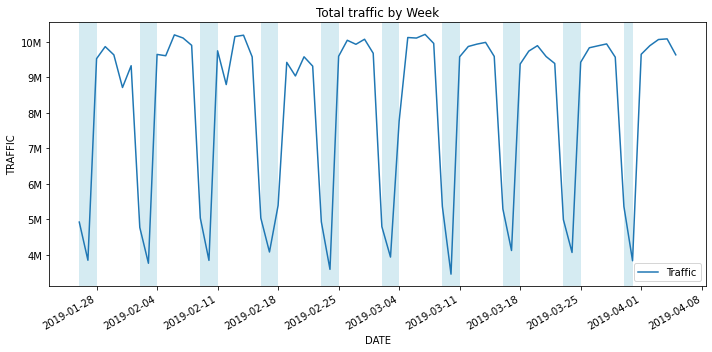

In [28]:
mta_bydate = mta_bystation.groupby('DATE').sum().reset_index()

fig, axs = plt.subplots(nrows=1,figsize=(10,5))

sns.lineplot(data = mta_bydate, x='DATE', y='TRAFFIC', ax=axs, label="Traffic").set(title='Total traffic by Week')

weekend_indices = p1.find_weekend_indices(mta_bydate.DATE.tolist())
p1.highlight_datetimes(weekend_indices, axs, mta_bydate)

axs = plt.gca()

# set date ticks to beginning of each weekly dataset
axs.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))

# format number labels
axs.yaxis.set_major_formatter(tick.FuncFormatter(p1.reformat_large_tick_values));

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig('weekly_traffic_total-' + str(num_weeks) + 'wk.svg');

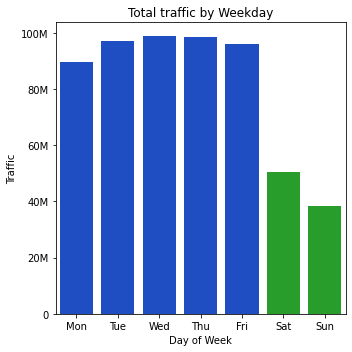

In [29]:
fig, axs = plt.subplots(nrows=1,figsize=(5,5))

with sns.xkcd_palette(['blue', 'blue', 'blue', 'blue', 'blue', 'green', 'green']):
    sns.barplot(data = mta_bystation.groupby('WEEKDAY_INDEX').sum().reset_index(), x='WEEKDAY_INDEX', y='TRAFFIC', ax=axs, label="Traffic").set(title='Total traffic by Weekday', xticklabels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], xlabel='Day of Week', ylabel='Traffic');

axs = plt.gca()
    
# format number labels
axs.yaxis.set_major_formatter(tick.FuncFormatter(p1.reformat_large_tick_values));

plt.tight_layout()
plt.savefig('weekly_traffic_byweekday-' + str(num_weeks) + 'wk.svg');

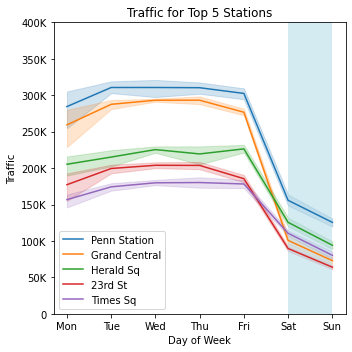

In [30]:
fig, axs = plt.subplots(nrows=1,figsize=(5,5))

for station in mta:
    sns.lineplot(data = mta[station][0], x='WEEKDAY_INDEX', y='TRAFFIC', ax=axs, label=mta[station][1]).set(title='Traffic for Top 5 Stations', ylim=(0,400000), xticklabels=['','Mon','Tue','Wed','Thu','Fri','Sat','Sun'], xlabel='Day of Week', ylabel='Traffic')

axs.axvspan(5, 6, facecolor='lightblue', edgecolor='none', alpha=.5)
        
axs.yaxis.set_major_formatter(tick.FuncFormatter(p1.reformat_large_tick_values))
axs.legend();

plt.tight_layout()
plt.savefig('top5traffic-' + str(num_weeks) + 'wk.svg')

In [31]:
mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"].at[427, 'DATE']

KeyError: 427

In [32]:
mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"].index[0]

4268

In [33]:
mta_stations = pd.read_excel("http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls")

In [34]:
mta_stations.head()

,Remote,Booth,Station,Line Name,Division
0,R001,A060,WHITEHALL ST,R1,BMT
1,R001,A058,WHITEHALL ST,R1,BMT
2,R001,R101S,SOUTH FERRY,R1,IRT
3,R002,A077,FULTON ST,ACJZ2345,BMT
4,R002,A081,FULTON ST,ACJZ2345,BMT


### TODO:

- transit data from Feb 2 to Mar 29 2019
    - MVP: week ending Feb 2 2019
- header file for stations/booths (filtering by station)
    - MVP: top 5 stations
- focus on data between 8 am and 8 pm
    - MVP: focus on day (24 hour period)

### Immeadiate tasks:

- combine turnstile and station data
- plot data (day vs vol of passanger)


- combine data from different weeks
- filter/group data by station
- columns: stations, station exits, day of week, number of exits, number of entrances
- determine the difference between REGULAR and RECOVER AUD in DESC column ->> RECOVER AUD adds recovered data after the fact
- group traffic data by stations, see trends on weekdays vs weekends


In [35]:
mta_station_geoloc = pd.read_json("https://data.ny.gov/resource/i9wp-a4ja.json")

In [36]:
mta_station_geoloc.head()

,division,line,station_name,station_latitude,station_longitude,route1,entrance_type,entry,vending,staffing,...,route4,route5,route6,route7,route8,route9,ada_notes,staff_hours,route10,route11
0,BMT,4 Avenue,25th St,40.660397,-73.998091,R,Stair,YES,YES,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BMT,4 Avenue,25th St,40.660397,-73.998091,R,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
mta_exits_geoloc = pd.read_csv("https://raw.githubusercontent.com/chriswhong/nycturnstiles/master/geocoded.csv", header=None, names=['Remote','Booth', 'Station Name', 'Station ID', 'Division', 'Latitute', 'Longitude'])

In [38]:
mta_exits_geoloc.head()

,Remote,Booth,Station Name,Station ID,Division,Latitute,Longitude
0,R470,X002,ELTINGVILLE PK,Z,SRT,40.544600,-74.164581
1,R544,PTH02,HARRISON,1,PTH,40.738879,-74.155533
2,R165,S102,TOMPKINSVILLE,1,SRT,40.636948,-74.074824
3,R070,S101,ST. GEORGE,1,SRT,40.643738,-74.073622
4,R070,S101A,ST. GEORGE,1,SRT,40.643738,-74.073622


In [39]:
pd.read_csv?

Signature:
pd.read_csv(
    filepath_or_buffer:Union[str, pathlib.Path, IO[~AnyStr]],
    sep=',',
    delimiter=None,
    header='infer',
    names=None,
    index_col=None,
    usecols=None,
    squeeze=False,
    prefix=None,
    mangle_dupe_cols=True,
    dtype=None,
    engine=None,
    converters=None,
    true_values=None,
    false_values=None,
    skipinitialspace=False,
    skiprows=None,
    skipfooter=0,
    nrows=None,
    na_values=None,
    keep_default_na=True,
    na_filter=True,
    verbose=False,
    skip_blank_lines=True,
    parse_dates=False,
    infer_datetime_format=False,
    keep_date_col=False,
    date_parser=None,
    dayfirst=False,
    cache_dates=True,
    iterator=False,
    chunksize=None,
    compression='infer',
    thousands=None,
    decimal:str='.',
    lineterminator=None,
    quotechar='"',
    quoting=0,
    doublequote=True,
    escapechar=None,
    comment=None,
    encoding=None,
    dialect=None,
    error_bad_lines=True,
    warn_bad_lines